Transformer implementation from https://wingedsheep.com/building-a-language-model/ (and a little bit from x-transformers)

In [3]:
import random
from typing import List

import torch
import numpy as np

import matplotlib.pyplot as plt


class TokenEmbedding(torch.nn.Module):
    """
    PyTorch module that converts tokens into embeddings.

    Input dimension is: (batch_size, sequence_length)
    Output dimension is: (batch_size, sequence_length, d_model)
    """

    def __init__(self, d_model, number_of_tokens):
        super().__init__()
        self.embedding_layer = torch.nn.Embedding(
            num_embeddings=number_of_tokens,
            embedding_dim=d_model
        )

    def forward(self, x):
        return self.embedding_layer(x)


class PositionalEncoding(torch.nn.Module):
    """
    Pytorch module that creates a positional encoding matrix. This matrix will later be added to the
    transformer's input embeddings to provide a sense of position of the sequence elements.
    """

    def __init__(self, d_model, max_sequence_length):
        super().__init__()
        self.d_model = d_model
        self.max_sequence_length = max_sequence_length
        self.positional_encoding = self.create_positional_encoding()

    def create_positional_encoding(self):
        """
        Creates a positional encoding matrix of size (max_sequence_length, d_model).
        """

        # Initialize positional encoding matrix
        positional_encoding = np.zeros((self.max_sequence_length, self.d_model))

        # Calculate positional encoding for each position and each dimension
        for pos in range(self.max_sequence_length):
            for i in range(0, self.d_model, 2):
                # Apply sin to even indices in the array; indices in Python start at 0 so i is even.
                positional_encoding[pos, i] = np.sin(pos / (10000 ** ((2 * i) / self.d_model)))

                if i + 1 < self.d_model:
                    # Apply cos to odd indices in the array; we add 1 to i because indices in Python start at 0.
                    positional_encoding[pos, i + 1] = np.cos(pos / (10000 ** ((2 * i) / self.d_model)))

        # Convert numpy array to PyTorch tensor and return it
        return torch.from_numpy(positional_encoding).float().to(get_device())

    def forward(self, x):
        """
        Adds the positional encoding to the input embeddings at the corresponding positions.
        """
        # Add positional encodings to input embeddings. The ":" indexing ensures we only add positional encodings up
        # to the length of the sequence in the batch. x.size(0) is the batch size, so this is a way to make sure
        # we're not adding extra positional encodings.
        return x + self.positional_encoding[:x.size(1), :]


class MaskedSelfAttention(torch.nn.Module):
    """
    Pytorch module for a self attention layer.
    This layer is used in the MultiHeadedSelfAttention module.

    Input dimension is: (batch_size, sequence_length, embedding_dimension)
    Output dimension is: (batch_size, sequence_length, head_dimension)
    """

    def __init__(self, embedding_dimension, head_dimension):
        super().__init__()
        self.embedding_dimension = embedding_dimension
        self.head_dimension = head_dimension
        self.query_layer = torch.nn.Linear(embedding_dimension, self.head_dimension)
        self.key_layer = torch.nn.Linear(embedding_dimension, self.head_dimension)
        self.value_layer = torch.nn.Linear(embedding_dimension, self.head_dimension)
        self.softmax = torch.nn.Softmax(dim=-1)

    def forward(self, x, mask):
        """
        Compute the self attention.

        x dimension is: (batch_size, sequence_length, embedding_dimension)
        output dimension is: (batch_size, sequence_length, head_dimension)
        mask dimension is: (batch_size, sequence_length)

        mask values are: 0 or 1. 0 means the token is masked, 1 means the token is not masked.
        """

        # x dimensions are: (batch_size, sequence_length, embedding_dimension)
        # query, key, value dimensions are: (batch_size, sequence_length, head_dimension)
        query = self.query_layer(x)
        key = self.key_layer(x)
        value = self.value_layer(x)

        # Calculate the attention weights.
        # attention_weights dimensions are: (batch_size, sequence_length, sequence_length)
        attention_weights = torch.matmul(query, key.transpose(-2, -1))

        # Scale the attention weights.
        attention_weights = attention_weights / np.sqrt(self.head_dimension)

        # Apply the mask to the attention weights, by setting the masked tokens to a very low value.
        # This will make the softmax output 0 for these values.
        mask = mask.reshape(attention_weights.shape[0], 1, attention_weights.shape[2])
        attention_weights = attention_weights.masked_fill(mask == 0, -1e9)

        # Softmax makes sure all scores are between 0 and 1 and the sum of scores is 1.
        # attention_scores dimensions are: (batch_size, sequence_length, sequence_length)
        attention_scores = self.softmax(attention_weights)

        # The attention scores are multiplied by the value
        # Values of tokens with high attention score get highlighted because they are multiplied by a larger number,
        # and tokens with low attention score get drowned out because they are multiplied by a smaller number.
        # Output dimensions are: (batch_size, sequence_length, head_dimension)
        return torch.bmm(attention_scores, value)


class MaskedMultiHeadedSelfAttention(torch.nn.Module):
    """
    Pytorch module for a multi head attention layer.

    Input dimension is: (batch_size, sequence_length, embedding_dimension)
    Output dimension is: (batch_size, sequence_length, embedding_dimension)
    """

    def __init__(self, embedding_dimension, number_of_heads):
        super().__init__()
        self.embedding_dimension = embedding_dimension
        self.head_dimension = embedding_dimension // number_of_heads
        self.number_of_heads = number_of_heads

        # Create the self attention modules
        self.self_attentions = torch.nn.ModuleList(
            [MaskedSelfAttention(embedding_dimension, self.head_dimension) for _ in range(number_of_heads)])

        # Create a linear layer to combine the outputs of the self attention modules
        self.output_layer = torch.nn.Linear(number_of_heads * self.head_dimension, embedding_dimension)

    def forward(self, x, mask):
        """
        Compute the multi head attention.

        x dimensions are: (batch_size, sequence_length, embedding_dimension)
        mask dimensions are: (batch_size, sequence_length)
        mask values are: 0 or 1. 0 means the token is masked, 1 means the token is not masked.
        """
        # Compute the self attention for each head
        # self_attention_outputs dimensions are:
        # (number_of_heads, batch_size, sequence_length, head_dimension)
        self_attention_outputs = [self_attention(x, mask) for self_attention in self.self_attentions]

        # Concatenate the self attention outputs
        # self_attention_outputs_concatenated dimensions are:
        # (batch_size, sequence_length, number_of_heads * head_dimension)
        concatenated_self_attention_outputs = torch.cat(self_attention_outputs, dim=2)

        # Apply the output layer to the concatenated self attention outputs
        # output dimensions are: (batch_size, sequence_length, embedding_dimension)
        return self.output_layer(concatenated_self_attention_outputs)


class FeedForward(torch.nn.Module):
    """
    Pytorch module for a feed forward layer.

    A feed forward layer is a fully connected layer with a ReLU activation function in between.
    """

    def __init__(self, embedding_dimension, feed_forward_dimension):
        super().__init__()
        self.embedding_dimension = embedding_dimension
        self.feed_forward_dimension = feed_forward_dimension
        self.linear_1 = torch.nn.Linear(embedding_dimension, feed_forward_dimension)
        self.linear_2 = torch.nn.Linear(feed_forward_dimension, embedding_dimension)

    def forward(self, x):
        """
        Compute the feed forward layer.
        """
        return self.linear_2(torch.relu(self.linear_1(x)))


class DecoderLayer(torch.nn.Module):
    """
    Pytorch module for an encoder layer.

    An encoder layer consists of a multi-headed self attention layer, a feed forward layer and dropout.

    Input dimension is: (batch_size, sequence_length, embedding_dimension)
    Output dimension is: (batch_size, sequence_length, embedding_dimension)
    """

    def __init__(
            self,
            embedding_dimension,
            number_of_heads,
            feed_forward_dimension,
            dropout_rate
    ):
        super().__init__()
        self.embedding_dimension = embedding_dimension
        self.number_of_heads = number_of_heads
        self.feed_forward_dimension = feed_forward_dimension
        self.dropout_rate = dropout_rate

        self.multi_headed_self_attention = MaskedMultiHeadedSelfAttention(embedding_dimension, number_of_heads)
        self.feed_forward = FeedForward(embedding_dimension, feed_forward_dimension)
        self.dropout = torch.nn.Dropout(dropout_rate)
        self.layer_normalization_1 = torch.nn.LayerNorm(embedding_dimension)
        self.layer_normalization_2 = torch.nn.LayerNorm(embedding_dimension)

    def forward(self, x, mask):
        """
        Compute the encoder layer.

        x dimensions are: (batch_size, sequence_length, embedding_dimension)
        mask dimensions are: (batch_size, sequence_length)
        mask values are: 0 or 1. 0 means the token is masked, 1 means the token is not masked.
        """

        # Layer normalization 1
        normalized_x = self.layer_normalization_1(x)

        # Multi headed self attention
        attention_output = self.multi_headed_self_attention(normalized_x, mask)

        # Residual output
        residual_output = x + attention_output

        # Layer normalization 2
        normalized_residual_output = self.layer_normalization_2(residual_output)

        # Feed forward
        feed_forward_output = self.feed_forward(normalized_residual_output)

        # Dropout
        if self.training:
            feed_forward_output = self.dropout(feed_forward_output)

        # Residual output
        return residual_output + feed_forward_output


class DecoderStack(torch.nn.Module):
    """
    The decoder stack consists of multiple decoder layers in sequence.
    """

    def __init__(
            self,
            embedding_dimension,
            number_of_layers,
            number_of_heads,
            feed_forward_dimension,
            dropout_rate,
            max_sequence_length
    ):
        super().__init__()
        self.embedding_dimension = embedding_dimension
        self.number_of_layers = number_of_layers
        self.number_of_heads = number_of_heads
        self.feed_forward_dimension = feed_forward_dimension
        self.dropout_rate = dropout_rate
        self.max_sequence_length = max_sequence_length

        # Create the encoder layers
        self.encoder_layers = torch.nn.ModuleList(
            [DecoderLayer(embedding_dimension, number_of_heads, feed_forward_dimension, dropout_rate) for _ in
             range(number_of_layers)])

    def forward(self, x, mask):
        decoder_outputs = x
        for decoder_layer in self.encoder_layers:
            decoder_outputs = decoder_layer(decoder_outputs, mask)

        return decoder_outputs


class LMHead(torch.nn.Module):
    """
    Pytorch module for the language model head.
    The language model head is a linear layer that maps the embedding dimension to the vocabulary size.
    """

    def __init__(self, embedding_dimension, number_of_tokens):
        super().__init__()
        self.embedding_dimension = embedding_dimension
        self.number_of_tokens = number_of_tokens
        self.linear = torch.nn.Linear(embedding_dimension, number_of_tokens)

    def forward(self, x):
        """
        Compute the language model head.

        x dimensions are: (batch_size, sequence_length, embedding_dimension)
        output dimensions are: (batch_size, sequence_length, number_of_tokens)
        """
        # Compute the linear layer
        # linear_output dimensions are: (batch_size, sequence_length, number_of_tokens)
        linear_output = self.linear(x)

        return linear_output


class LanguageModel(torch.nn.Module):
    """
    Pytorch module for a language model.
    """

    def __init__(
            self,
            number_of_tokens,  # The number of tokens in the vocabulary
            max_sequence_length=512,  # The maximum sequence length to use for attention
            embedding_dimension=512,  # The dimension of the token embeddings
            number_of_layers=6,  # The number of decoder layers to use
            number_of_heads=4,  # The number of attention heads to use
            feed_forward_dimension=None,  # The dimension of the feed forward layer
            dropout_rate=0.1  # The dropout rate to use
    ):
        super().__init__()
        self.number_of_tokens = number_of_tokens
        self.max_sequence_length = max_sequence_length
        self.embedding_dimension = embedding_dimension
        self.number_of_layers = number_of_layers
        self.number_of_heads = number_of_heads

        if feed_forward_dimension is None:
            # GPT-2 paper uses 4 * embedding_dimension for the feed forward dimension
            self.feed_forward_dimension = embedding_dimension * 4
        else:
            self.feed_forward_dimension = feed_forward_dimension

        self.dropout_rate = dropout_rate

        # Create the token embedding layer
        self.token_embedding = TokenEmbedding(embedding_dimension, number_of_tokens)

        # Create the positional encoding layer
        self.positional_encoding = PositionalEncoding(embedding_dimension, max_sequence_length)

        # Create the normalization layer
        self.layer_normalization = torch.nn.LayerNorm(embedding_dimension)

        # Create the decoder stack
        self.decoder = DecoderStack(
            embedding_dimension=embedding_dimension,
            number_of_layers=number_of_layers,
            number_of_heads=number_of_heads,
            feed_forward_dimension=self.feed_forward_dimension,
            dropout_rate=dropout_rate,
            max_sequence_length=max_sequence_length
        )

        # Create the language model head
        self.lm_head = LMHead(embedding_dimension, number_of_tokens)

    def forward(self, x, mask):
        # Compute the token embeddings
        # token_embeddings dimensions are: (batch_size, sequence_length, embedding_dimension)
        token_embeddings = self.token_embedding(x)

        # Compute the positional encoding
        # positional_encoding dimensions are: (batch_size, sequence_length, embedding_dimension)
        positional_encoding = self.positional_encoding(token_embeddings)

        # Post embedding layer normalization
        positional_encoding_normalized = self.layer_normalization(positional_encoding)

        decoder_outputs = self.decoder(positional_encoding_normalized, mask)
        lm_head_outputs = self.lm_head(decoder_outputs)

        return lm_head_outputs

    def save_checkpoint(self, path):
        print(f'Saving checkpoint {path}')
        torch.save({
            'number_of_tokens': self.number_of_tokens,
            'max_sequence_length': self.max_sequence_length,
            'embedding_dimension': self.embedding_dimension,
            'number_of_layers': self.number_of_layers,
            'number_of_heads': self.number_of_heads,
            'feed_forward_dimension': self.feed_forward_dimension,
            'dropout_rate': self.dropout_rate,
            'model_state_dict': self.state_dict()
        }, path)

    @staticmethod
    def load_checkpoint(path) -> 'LanguageModel':
        checkpoint = torch.load(path)
        model = LanguageModel(
            number_of_tokens=checkpoint['number_of_tokens'],
            max_sequence_length=checkpoint['max_sequence_length'],
            embedding_dimension=checkpoint['embedding_dimension'],
            number_of_layers=checkpoint['number_of_layers'],
            number_of_heads=checkpoint['number_of_heads'],
            feed_forward_dimension=checkpoint['feed_forward_dimension'],
            dropout_rate=checkpoint['dropout_rate']
        )
        model.load_state_dict(checkpoint['model_state_dict'])
        return model.to(get_device())


class AutoregressiveWrapper(torch.nn.Module):
    """
    Pytorch module that wraps a GPT model and makes it autoregressive.
    """

    def __init__(self, gpt_model):
        super().__init__()
        self.model = gpt_model
        self.max_sequence_length = self.model.max_sequence_length

    def forward(self, x, mask):
        """
        Autoregressive forward pass
        """
        inp, target = x[:, :-1], x[:, 1:]
        mask = mask[:, :-1]

        output = self.model(inp, mask)
        return output, target

    def next_token_probabilities(self, x, mask, temperature=1.0):
        """
        Calculate the token probabilities for the next token in the sequence.
        """
        logits = self.model(x, mask)[:, -1]

        # Apply temperature
        if temperature != 1.0:
            logits = logits / temperature

        # Apply the softmax
        probabilities = torch.softmax(logits, dim=-1)

        return probabilities

    def save_checkpoint(self, path):
        self.model.save_checkpoint(path)

    @staticmethod
    def load_checkpoint(path) -> 'AutoregressiveWrapper':
        model = LanguageModel.load_checkpoint(path)
        return AutoregressiveWrapper(model).to(get_device())


class Tokenizer:

    def __init__(self):
        self.dictionary = {}
        self.reverse_dictionary = {}

        # Add the padding token
        self.__add_to_dict('<pad>')

        # Add characters and numbers to the dictionary
        for i in range(10):
            self.__add_to_dict(str(i))
        for i in range(26):
            self.__add_to_dict(chr(ord('a') + i))

        # Add space and punctuation to the dictionary
        self.__add_to_dict('.')
        self.__add_to_dict(' ')

    def __add_to_dict(self, character):
        if character not in self.dictionary:
            self.dictionary[character] = len(self.dictionary)
            self.reverse_dictionary[self.dictionary[character]] = character

    def tokenize(self, text):
        return [self.dictionary[c] for c in text]

    def character_to_token(self, character):
        return self.dictionary[character]

    def token_to_character(self, token):
        return self.reverse_dictionary[token]

    def size(self):
        return len(self.dictionary)


def get_device():
    return torch.device("cuda" if torch.cuda.is_available() else "cpu")


class Trainer:

    def __init__(self, model, tokenizer: Tokenizer, optimizer=None):
        super().__init__()
        self.model = model
        if optimizer is None:
            self.optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
        else:
            self.optimizer = optimizer
        self.tokenizer = tokenizer
        self.loss_function = torch.nn.CrossEntropyLoss()

    def train(self, data: List[str], epochs, batch_size):
        loss_per_epoch = []
        for epoch in range(epochs):
            losses = []

            # Shuffle the sequences
            random.shuffle(data)

            # Create batches of sequences and their respective mask.
            batches = []
            for i in range(0, len(data), batch_size):
                sequence_tensor = torch.tensor(data[i: i + batch_size], dtype=torch.long)

                # Create the mask tensor for the batch, where 1 means the token is not a padding token
                mask_tensor = torch.ones_like(sequence_tensor)
                mask_tensor[sequence_tensor == self.tokenizer.character_to_token('<pad>')] = 0

                batches.append((sequence_tensor, mask_tensor))

            # Train the model on each batch
            for batch in batches:
                self.model.train()

                # Create the input and mask tensors
                input_tensor = torch.zeros((batch_size, self.model.max_sequence_length + 1), dtype=torch.long)
                mask_tensor = torch.zeros((batch_size, self.model.max_sequence_length + 1), dtype=torch.long)

                for i, input_entry in enumerate(batch[0]):
                    input_tensor[i] = input_entry

                for i, mask_entry in enumerate(batch[1]):
                    mask_tensor[i] = mask_entry

                # Compute the model output
                model_output, target = self.model.forward(
                    x=input_tensor.to(get_device()),
                    mask=mask_tensor.to(get_device())
                )

                # Compute the losses
                # The loss is computed on the model output and the target
                loss = self.loss_function(model_output.transpose(1, 2), target)
                # loss = self.loss_function(model_output[:, -1, :], target[:, -1])

                # Backpropagate the loss.
                loss.backward()

                # Clip the gradients. This is used to prevent exploding gradients.
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), 0.5)

                # Update the model parameters. This is done by taking a step in the direction of the gradient.
                self.optimizer.step()

                # Reset the gradients. This is done so that the gradients from the previous batch
                # are not used in the next step.
                self.optimizer.zero_grad()

                # Append the loss to the list of losses, so that the average loss can be computed for this epoch.
                losses.append(loss.item())

            # Print the loss
            epoch_loss = np.average(losses)
            loss_per_epoch.append(epoch_loss)
            print('Epoch:', epoch, 'Loss:', epoch_loss)

        return loss_per_epoch


class Generator:

    def __init__(
            self,
            model,
            tokenizer):
        self.model = model
        self.tokenizer = tokenizer

    def generate(
            self,
            max_tokens_to_generate: int,
            prompt: str = None,
            temperature: float = 1.0,
            eos_token: int = None,
            padding_token: int = 0):

        self.model.eval()

        if prompt is None:
            start_tokens = [self.tokenizer.character_to_token(padding_token)]
        else:
            start_tokens = self.tokenizer.tokenize(prompt)

        input_tensor = torch.tensor(
            pad_left(
                sequence=start_tokens,
                final_length=self.model.max_sequence_length + 1,
                padding_token=padding_token
            ),
            dtype=torch.long
        ).to(get_device())

        num_dims = len(input_tensor.shape)

        if num_dims == 1:
            input_tensor = input_tensor[None, :]

        out = input_tensor
        for _ in range(max_tokens_to_generate):

            x = out[:, -self.model.max_sequence_length:]

            mask = torch.ones_like(x)
            mask[x == padding_token] = 0

            # Compute the next token probabilities
            next_token_probabilities = self.model.next_token_probabilities(
                x=x,
                temperature=temperature,
                mask=mask
            )

            # Sample the next token from the probability distribution
            next_token = torch.multinomial(next_token_probabilities, num_samples=1)

            # Append the next token to the output
            out = torch.cat([out, next_token], dim=1)

            # If the end of sequence token is reached, stop generating tokens
            if eos_token is not None and next_token == eos_token:
                break

        generated_tokens = out[0].tolist()
        return ''.join([self.tokenizer.token_to_character(token) for token in generated_tokens])


def create_training_sequences(max_sequence_length, tokenized_training_data):
    # Create sequences of length max_sequence_length + 1
    # The last token of each sequence is the target token
    sequences = []
    for i in range(0, len(tokenized_training_data) - max_sequence_length - 1):
        sequences.append(tokenized_training_data[i: i + max_sequence_length + 1])
    return sequences


def tokenize_and_pad_training_data(max_sequence_length, tokenizer, training_data):
    # Tokenize the training data
    tokenized_training_data = tokenizer.tokenize(training_data)
    for _ in range(max_sequence_length):
        # Prepend padding tokens
        tokenized_training_data.insert(0, tokenizer.character_to_token('<pad>'))
    return tokenized_training_data

Epoch: 0 Loss: 2.644440096616745
Epoch: 1 Loss: 1.919064012169838
Epoch: 2 Loss: 1.6657718479633332
Epoch: 3 Loss: 1.489954298734665
Epoch: 4 Loss: 1.3466267257928848
Epoch: 5 Loss: 1.2159163817763328
Epoch: 6 Loss: 1.0945930540561677
Epoch: 7 Loss: 0.9826049834489823
Epoch: 8 Loss: 0.8793779790401459
Epoch: 9 Loss: 0.7762208022177219
Epoch: 10 Loss: 0.70168916285038
Epoch: 11 Loss: 0.6262750118970871
Epoch: 12 Loss: 0.5616555750370026
Epoch: 13 Loss: 0.49074860736727716
Epoch: 14 Loss: 0.42440066337585447
Epoch: 15 Loss: 0.36010941974818705
Epoch: 16 Loss: 0.3141226787120104
Epoch: 17 Loss: 0.27220613677054645
Epoch: 18 Loss: 0.23939418867230416
Epoch: 19 Loss: 0.20851999558508397
Epoch: 20 Loss: 0.18667917959392072
Epoch: 21 Loss: 0.15562305748462676
Epoch: 22 Loss: 0.14083945490419864
Epoch: 23 Loss: 0.12673422191292047
Epoch: 24 Loss: 0.10901936031877994
Epoch: 25 Loss: 0.0973500121384859
Epoch: 26 Loss: 0.08817372210323811
Epoch: 27 Loss: 0.07545622121542692
Epoch: 28 Loss: 0.0648

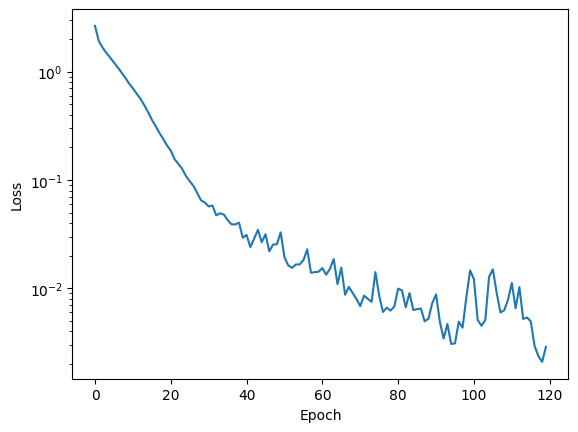

Saving checkpoint ./trained_model
cats rule the world. dogs are the best. elephants have long trunks. monkeys like bananas. pandas eat bamboo. tigers are dangerous. zebras have stripes. lions are the kings of the savannah. giraffes have long necks. hippos are big and scary. rhinos have horns. penguins live in the arctic. polar bears are whithe e the sthest. oooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooo


In [4]:
class Runner(torch.nn.Module):

    def __init__(self):
        super().__init__()

    def run(self):
        # Create the tokenizer
        tokenizer = Tokenizer()

        embedding_dimension = 256
        max_sequence_length = 20
        number_of_tokens = tokenizer.size()

        # Create the model
        model = AutoregressiveWrapper(LanguageModel(
            embedding_dimension=embedding_dimension,
            number_of_tokens=number_of_tokens,
            number_of_heads=4,
            number_of_layers=3,
            dropout_rate=0.1,
            max_sequence_length=max_sequence_length
        )).to(get_device())

        # Create the training data
        training_data = '. '.join([
            'cats rule the world',
            'dogs are the best',
            'elephants have long trunks',
            'monkeys like bananas',
            'pandas eat bamboo',
            'tigers are dangerous',
            'zebras have stripes',
            'lions are the kings of the savannah',
            'giraffes have long necks',
            'hippos are big and scary',
            'rhinos have horns',
            'penguins live in the arctic',
            'polar bears are white'
        ])

        tokenized_and_padded_training_data = tokenize_and_pad_training_data(max_sequence_length, tokenizer, training_data)
        sequences = create_training_sequences(max_sequence_length, tokenized_and_padded_training_data)

        # Train the model
        optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
        trainer = Trainer(model, tokenizer, optimizer)
        loss_per_epoch = trainer.train(sequences, epochs=120, batch_size=16)

        # Plot the loss per epoch in log scale
        plt.plot(loss_per_epoch)
        plt.yscale('log')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.show()

        model.save_checkpoint('./trained_model')

        # Generate text
        max_tokens_to_generate = 400
        generator = Generator(model, tokenizer)
        generated_text = generator.generate(
            max_tokens_to_generate=max_tokens_to_generate,
            prompt="cats",
            padding_token=tokenizer.character_to_token('<pad>')
        )
        print(generated_text.replace('<pad>', ''))


def pad_left(sequence, final_length, padding_token):
    return [padding_token] * (final_length - len(sequence)) + sequence


Runner().run()